In [1]:
%matplotlib inline  
import struct
from struct import unpack
from numpy import zeros, uint8, float32
from pylab import imshow, show, cm
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import subprocess


#Initialize for keras
import keras
from keras.datasets import mnist
from keras.models import Sequential, Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras import backend as K

Using TensorFlow backend.


In [2]:
# Define functions for reading data.
# Based on https://gist.github.com/tylerneylon/
def read_idx(filename):
    """
        Read from file and create numpy array
    """
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.fromstring(f.read(), dtype=np.uint8).reshape(shape)

def get_data(image_file, label_file, num_classes = 10, starts_at=0 ):
    """
        Read the image and label data
    """
    # Read the files
    pre_images = read_idx(image_file)
    pre_labels = read_idx(label_file)
    
    images = np.zeros((len(pre_images), 28,28, 1), dtype=np.float32)
    labels = np.zeros((len(pre_labels),num_classes), dtype=np.int8)
    for i in range(len(pre_images)):
        pre_img=pre_images[i]
        pre_label=pre_labels[i]-starts_at
        img = (pre_img.transpose() / 255.0)
        images[i] = img.reshape(28,28,1) 
        labels[i] = keras.utils.to_categorical(pre_label, num_classes)
    
    return images, labels

def file_len(fname):
    p = subprocess.Popen(['wc', '-l', fname], stdout=subprocess.PIPE, 
                                              stderr=subprocess.PIPE)
    result, err = p.communicate()
    if p.returncode != 0:
        raise IOError(err)
    return int(result.strip().split()[0])

In [3]:
train_mapping_file = '/home/carnd/data/emnist/emnist-letters-mapping.txt'
num_classes = file_len(train_mapping_file)
train_image_file = '/home/carnd/data/emnist/emnist-letters-train-images-idx3-ubyte'
train_label_file = '/home/carnd/data/emnist/emnist-letters-train-labels-idx1-ubyte'
train_images, train_labels = get_data(train_image_file, train_label_file,num_classes, 1)
print ('Training Data')
print ('Images Shape: {}'.format(train_images.shape))
print ('Labels Shape: {}'.format(train_labels.shape))

test_image_file = '/home/carnd/data/emnist/emnist-letters-test-images-idx3-ubyte'
test_label_file = '/home/carnd/data/emnist/emnist-letters-test-labels-idx1-ubyte'
test_images, test_labels = get_data(test_image_file, test_label_file,num_classes,1)
print ('Training Data')
print ('Images Shape: {}'.format(test_images.shape))
print ('Labels Shape: {}'.format(test_labels.shape))

Training Data
Images Shape: (124800, 28, 28, 1)
Labels Shape: (124800, 26)
Training Data
Images Shape: (20800, 28, 28, 1)
Labels Shape: (20800, 26)


Label - 22 : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0] 


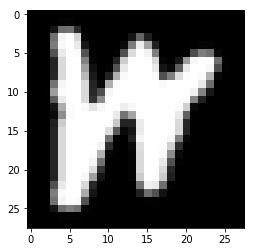

Label - 6 : [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 


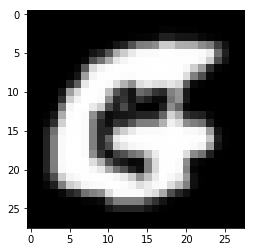

In [4]:
def view_image(image, label=""):
    """View a single image."""
    print("Label - {} : {} ".format(np.argmax(label), label))
    plt.imshow((image.reshape(28,28)), cmap="gray")
    plt.show()

for i in range(2):
    view_image(train_images[i], train_labels[i])

In [5]:
# Train, Test split
from sklearn.model_selection import train_test_split
X_val, X_test, y_val, y_test = train_test_split(test_images, test_labels, test_size=0.5, random_state=42)

In [6]:
# Initialize the hyperparameters
input_shape = (28,28, 1)

In [7]:
# Build model
inputs = Input(shape=input_shape)
conv = Conv2D(32, (7, 7), strides=(1, 1), padding='same', name = "conv1", activation='relu')(inputs)
conv = Dropout(0.4)(conv)
conv = MaxPooling2D((2, 2))(conv)
conv = Conv2D(64, (5, 5), strides=(1, 1), padding='same', name = "conv2", activation='relu')(conv)
conv = Dropout(0.4)(conv)
conv = MaxPooling2D((2, 2))(conv)
conv = Conv2D(128, (3, 3), strides=(1, 1), padding='same', name = "conv3", activation='relu')(conv)
conv = Dropout(0.4)(conv)
conv = MaxPooling2D((2, 2))(conv)
conv = Conv2D(256, (3, 3), strides=(1, 1), padding='same', name = "conv4", activation='relu')(conv)
flat = Flatten()(conv)
dense = Dense(128, activation='relu', name = "dense2")(flat)
dropout = Dropout(0.4)(dense)
outputs = Dense(num_classes, activation='softmax', name = "output")(dropout)

model = Model(inputs=inputs, outputs=outputs)

model.summary()
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Nadam(),
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 28, 28, 32)        1600      
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 14, 14, 64)        51264     
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
__________

In [8]:
batch_size = 1000
epochs = 50
history = model.fit(train_images, train_labels,
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          validation_data=(X_val, y_val))

Train on 124800 samples, validate on 10400 samples
Epoch 1/50
44s - loss: 1.2092 - acc: 0.6442 - val_loss: 0.6036 - val_acc: 0.9132
Epoch 2/50
37s - loss: 0.2971 - acc: 0.9053 - val_loss: 0.4143 - val_acc: 0.9298
Epoch 3/50
37s - loss: 0.2299 - acc: 0.9254 - val_loss: 0.3745 - val_acc: 0.9367
Epoch 4/50
37s - loss: 0.1978 - acc: 0.9352 - val_loss: 0.3250 - val_acc: 0.9411
Epoch 5/50
37s - loss: 0.1836 - acc: 0.9387 - val_loss: 0.3003 - val_acc: 0.9423
Epoch 6/50
37s - loss: 0.1718 - acc: 0.9420 - val_loss: 0.2841 - val_acc: 0.9419
Epoch 7/50
37s - loss: 0.1636 - acc: 0.9439 - val_loss: 0.2571 - val_acc: 0.9453
Epoch 8/50
37s - loss: 0.1557 - acc: 0.9461 - val_loss: 0.2640 - val_acc: 0.9448
Epoch 9/50
37s - loss: 0.1484 - acc: 0.9482 - val_loss: 0.2457 - val_acc: 0.9494
Epoch 10/50
37s - loss: 0.1466 - acc: 0.9490 - val_loss: 0.2487 - val_acc: 0.9444
Epoch 11/50
37s - loss: 0.1391 - acc: 0.9504 - val_loss: 0.2383 - val_acc: 0.9488
Epoch 12/50
37s - loss: 0.1380 - acc: 0.9503 - val_loss:

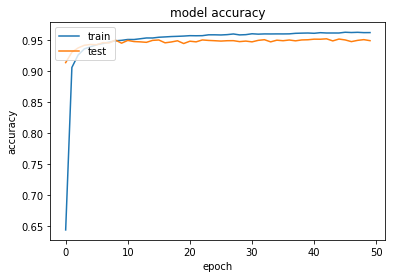

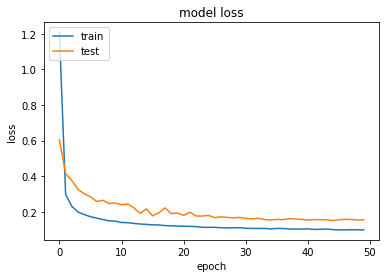

In [9]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [10]:
score = model.evaluate(X_test, y_test, verbose=1, batch_size=batch_size)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10400 [===========================>..] - ETA: 0sTest loss: 0.159593482144
Test accuracy: 0.94798081884
